In [1]:
#Importing main libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib  # for saving/loading the model

#MImporting libries for feature engineering and Model training

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import r2_score
from customencoder import FrequencyEncoder
import xgboost as xgb

# PDP and SHAP

from sklearn.inspection import PartialDependenceDisplay
import shap



In [2]:
# Importing Data

data = pd.read_csv(r"C:\Users\ruksh\Desktop\Data_science\Data\International_Education_Costs.csv")

In [3]:
## EDA - Statistics

#Printing column names
print(data.columns)

#Data types of each column
print(data.dtypes)

#Check for missing values
print(data.isna().sum())

#Data statistics
print(data.describe())

print(data.nunique)

Index(['Country', 'City', 'University', 'Program', 'Level', 'Duration_Years',
       'Tuition_USD', 'Living_Cost_Index', 'Rent_USD', 'Visa_Fee_USD',
       'Insurance_USD', 'Exchange_Rate'],
      dtype='object')
Country               object
City                  object
University            object
Program               object
Level                 object
Duration_Years       float64
Tuition_USD            int64
Living_Cost_Index    float64
Rent_USD               int64
Visa_Fee_USD           int64
Insurance_USD          int64
Exchange_Rate        float64
dtype: object
Country              0
City                 0
University           0
Program              0
Level                0
Duration_Years       0
Tuition_USD          0
Living_Cost_Index    0
Rent_USD             0
Visa_Fee_USD         0
Insurance_USD        0
Exchange_Rate        0
dtype: int64
       Duration_Years   Tuition_USD  Living_Cost_Index     Rent_USD  \
count      907.000000    907.000000         907.000000   907.0000

In [4]:
# Column selection and categorization 
x=data.drop(['Tuition_USD', 'University','Program'],axis=1)
y=data['Tuition_USD']

cat=['Country', 'City', 'Level']
num=['Duration_Years','Living_Cost_Index', 'Rent_USD', 'Visa_Fee_USD','Insurance_USD', 'Exchange_Rate']



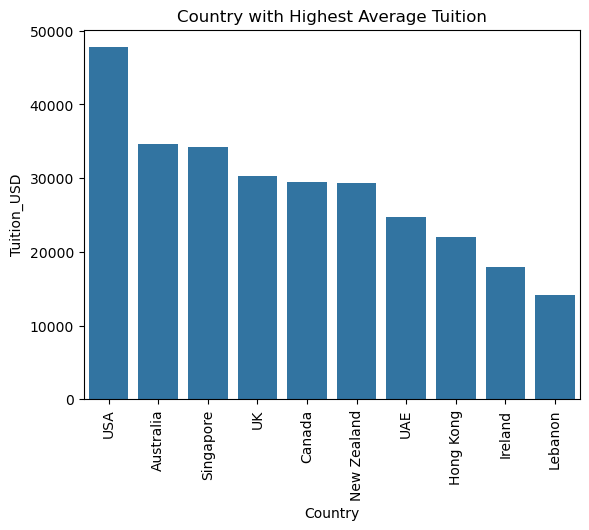

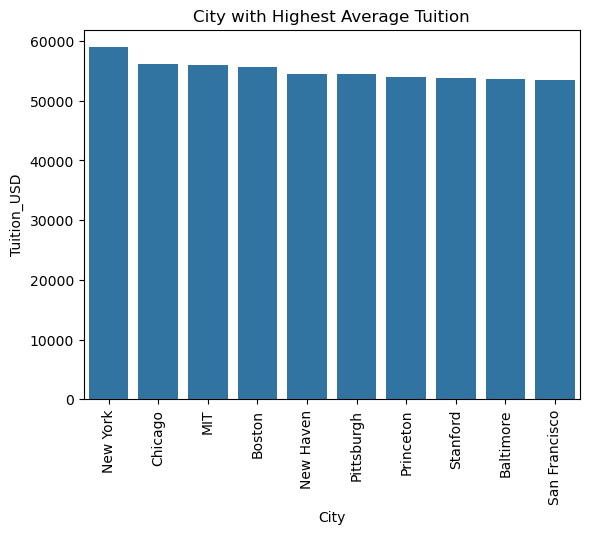

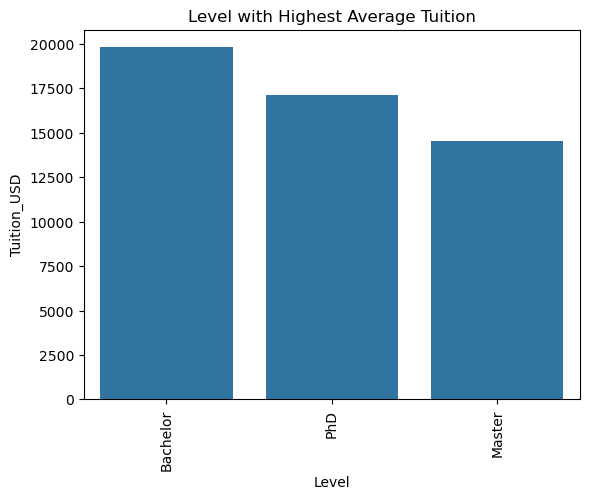

In [5]:
# EDA - Plots (Tuition variation with categorical variables - barplots)

for category in cat: 
    top_10 = pd.DataFrame(
    data.groupby(category)['Tuition_USD'].mean().nlargest(10)
    ).reset_index()

    sns.barplot(x=category,y='Tuition_USD',data=top_10)
    plt.xticks(rotation=90)
    plt.title(f'{category} with Highest Average Tuition')
    
    #plt.tight_layout()
    plt.show()

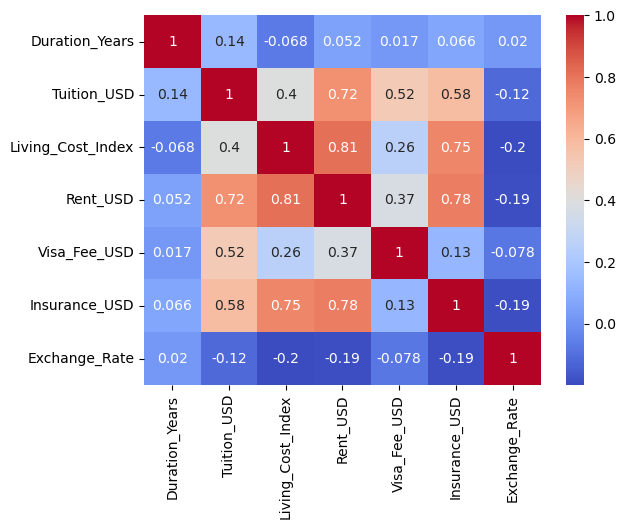

In [6]:
## EDA - Plots (Pairwise relationships/correlations between numberical variables)

data_numerical = data[['Duration_Years','Tuition_USD', 'Living_Cost_Index', 'Rent_USD', 'Visa_Fee_USD','Insurance_USD', 'Exchange_Rate']]
sns.heatmap(data_numerical.corr(), annot=True, cmap='coolwarm')
plt.show()

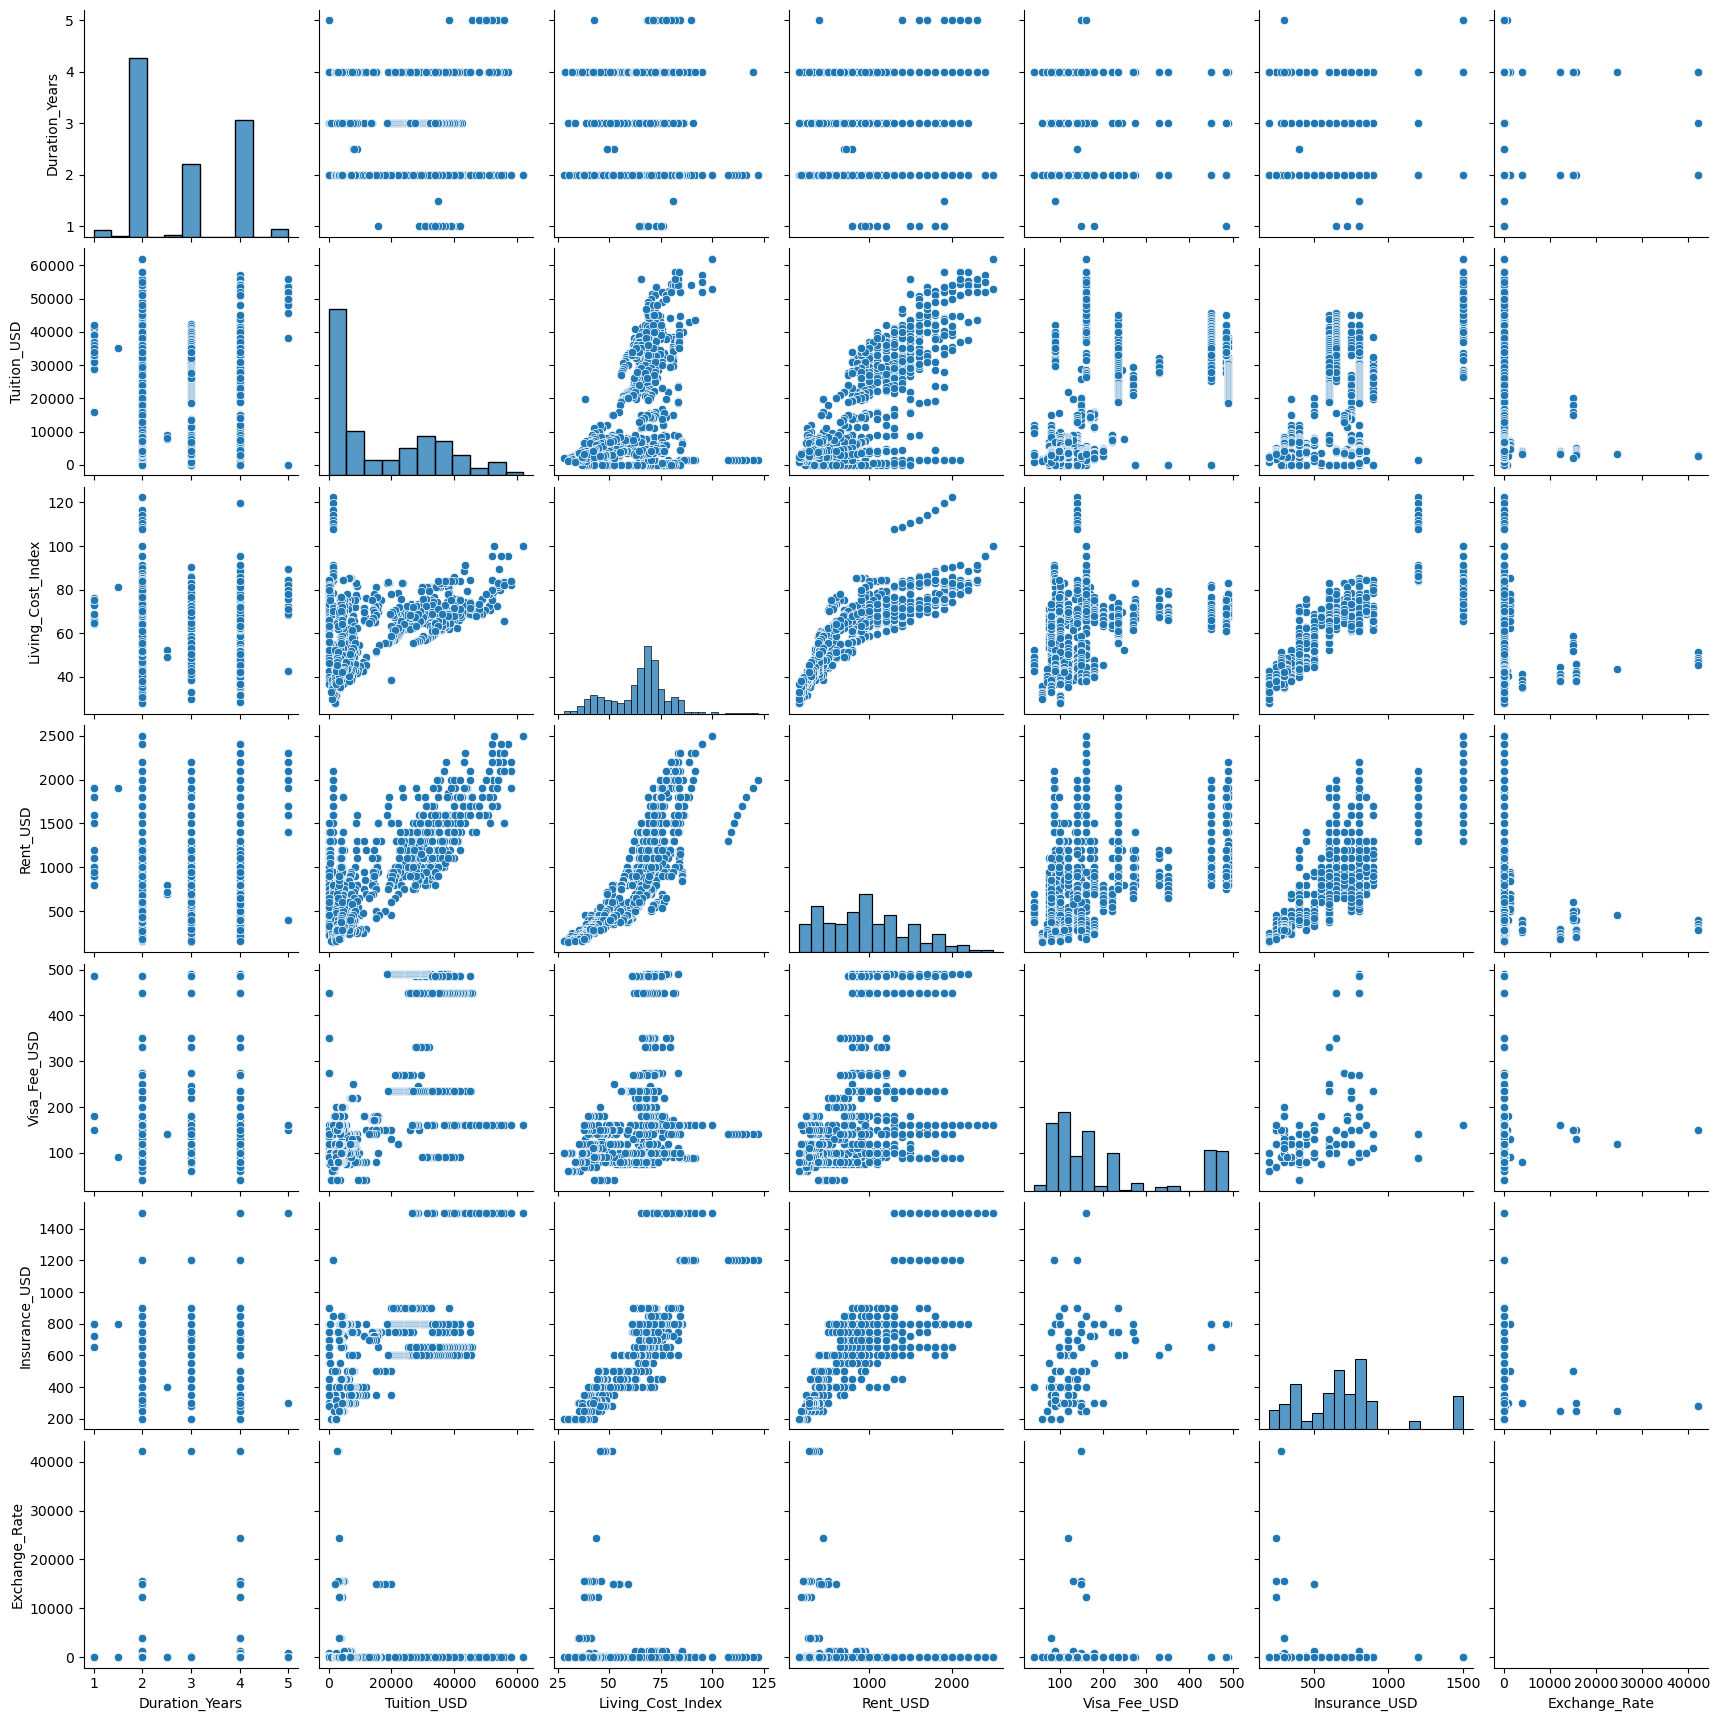

In [7]:
# EDA - Plots (Pairplots to observe relationships)

sns.pairplot(data_numerical)

In [8]:
## Determining levels in each categorical column. 

# This is important in selecting the proper encoding method. For example, large number of unique levels leads to high-cardinality categoricals.

print(data[cat].nunique())

Country     71
City       556
Level        3
dtype: int64


In [9]:
# Given the high cardinality in categorical data, frequescy encoding is more suitable for intepretability 

# Feature engineering 
ct = ColumnTransformer(transformers=[
                       ('num',StandardScaler(),num),
                       ('cat',FrequencyEncoder(),cat),
                        ])

# Model/pipeline training

model_pipeline=Pipeline([
    ('preprocessing',ct),
    ('model',xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1))
])



In [10]:
# Splitting the datasetand Training 
X_train, X_test, y_train, y_test = split(x, y, test_size=0.2, random_state=42)



In [11]:
# Transforming and Training in pipeline

model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Duration_Years',
                                                   'Living_Cost_Index',
                                                   'Rent_USD', 'Visa_Fee_USD',
                                                   'Insurance_USD',
                                                   'Exchange_Rate']),
                                                 ('cat', FrequencyEncoder(),
                                                  ['Country', 'City',
                                                   'Level'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [12]:
# Evaluation

predicted = model_pipeline.predict(X_test)

r2_score(y_test, predicted)

0.9686791300773621

In [ ]:
# PDP - If all else is kept constant, how does changing one feature affect the model's prediction?

X_test_transformed = model_pipeline.named_steps['preprocessing'].transform(X_test)
xgb_model = model_pipeline.named_steps['model']
feature_names = model_pipeline.named_steps['preprocessing'].get_feature_names_out()
features = list(range(len(feature_names)))

# Use transformed X data
PartialDependenceDisplay.from_estimator(
    estimator=xgb_model,
    X=X_test_transformed,                   
    features=features,
    feature_names=feature_names,               
    grid_resolution=50,
)

plt.subplots_adjust(hspace=0.8, wspace=0.8)
plt.show()
plt.savefig("PDP_plot.png")

## IMPORTANT

# PDP shows the average effect of a feature on predictions, assuming others stay constant.
# May be misleading when features are highly correlated (e.g., Living_Cost_Index, Rent, Insurance).


In [ ]:
## Model explainability with SHAP (how much each feature contributes to increasing or decreasing a prediction — for each individual data point.) 

# Create SHAP explainer
explainer = shap.Explainer(xgb_model, X_test_transformed)

# Compute SHAP values
shap_values = explainer(X_test_transformed)

shap_values.feature_names = feature_names

# Plot global interpretation
shap.plots.beeswarm(shap_values)
plt.savefig("shap_plot.png")

# === Summary ===
# - Feature importance (SHAP): 'cat__Country' has the highest contribution to predictions.
# - PDP showed limited effect for 'Living_Cost_Index' due to correlation with Rent and Insurance.
# - SHAP provided clearer, more accurate interpretability than XGBoost's built-in feature importance.

In [ ]:
#Saving the model

joblib.dump(model_pipeline, "model_pipeline.joblib")

In [ ]:
#Loading the model and inferencing with the loaded model with new data

#load_pipeline = joblib.load("model_pipeline.joblib")
#new_prediction = load_pipeline.predict(X_test)

In [ ]:
!jupyter nbconvert --to script tuition_estimater.ipynb
